95512


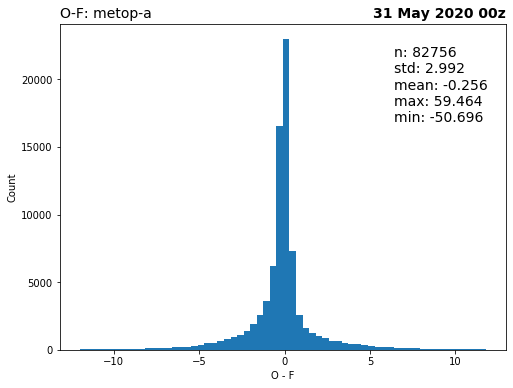

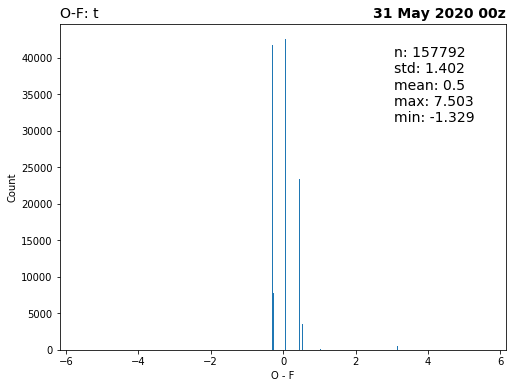

In [38]:
import numpy as np
from datetime import datetime
import yaml
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

sys.path.append('/home/Kevin.Dougherty/PyGSI/pyGSI')

from Diags import conventional, radiance


def plot_labels(metadata, stats):
    
    if metadata['Diag_type'] == 'conv' and metadata['Variable'] == 'q':
        t = ('n: %s\nstd: %s\nmean: %s\nmax: %s\nmin: %s' % (stats['N'],np.round(stats['Std'],6),np.round(stats['Mean'],6), np.round(stats['Max'],6), np.round(stats['Min'],6)))
    else:
        t = ('n: %s\nstd: %s\nmean: %s\nmax: %s\nmin: %s' % (stats['N'],np.round(stats['Std'],3),np.round(stats['Mean'],3), np.round(stats['Max'],3), np.round(stats['Min'],3)))
             
    
    if metadata['File_type'] == 'ges':
             
        xlabel     = " ".join(metadata['Data_type'])
        date_title = metadata['Date'].strftime("%d %b %Y %Hz")
             
        if metadata['Diag_type'] == 'conv':
            left_title = '{Data_type}: {Variable}'.format(**metadata)
            save_file  = '{Date:%Y%m%d%H}_{Diag_type}_{Variable}_O_minus_F'.format(**metadata)
        else:
            left_title = '{Data_type}: {Satellite}'.format(**metadata)
            save_file  = '{Date:%Y%m%d%H}_{Diag_type}_{Satellite}_O_minus_F'.format(**metadata)
             
    elif metadata['File_type'] == 'anl':
             
        xlabel     = " ".join(metadata['Data_type'])
        date_title = metadata['Date'].strftime("%d %b %Y %Hz")
             
        if metadata['Diag_type'] == 'conv':
            left_title = '{Data_type}: {Variable}'.format(**metadata)
            save_file  = '{Date:%Y%m%d%H}_{Diag_type}_{Variable}_O_minus_A'.format(**metadata)
        else:
            left_title = '{Data_type}: {Satellite}'.format(**metadata)
            save_file  = '{Date:%Y%m%d%H}_{Diag_type}_{Satellite}_O_minus_A'.format(**metadata)
             
    labels = {'statText'  : t,
              'xLabel'    : xlabel,
              'leftTitle' : left_title,
              'dateTitle' : date_title,
              'saveFile'  : save_file
             }
             
             
    return labels


def calculate_stats(data):
    
    n = np.count_nonzero(~np.isnan(data))
    
    mean = np.nanmean(data)
    std = np.nanstd(data)
    mx = np.nanmax(data)
    mn = np.nanmin(data)
    
    rmse = np.sqrt(np.nanmean(np.square(data)))
    
    stats = {'N'    : n,
             'Min'  : mn,
             'Max'  : mx,
             'Mean' : mean,
             'Std'  : std,
             'RMSE' : rmse
            }
    
    return stats


def plot_histogram(data, metadata):
    
    stats = calculate_stats(data) 
    
    binsize = (stats['Max']-stats['Min'])/np.sqrt(stats['N'])
    bins = np.arange(0-(4*stats['Std']),0+(4*stats['Std']),binsize)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    plt.hist(data, bins=bins)
             
    labels = plot_labels(metadata, stats)
             
    ax.text(0.75,.7, labels['statText'], fontsize=14, transform=ax.transAxes)
             
    plt.xlabel(labels['xLabel'])
    plt.ylabel('Count')
    
    title_split = labels['leftTitle'].split('\n')
    plt.title(labels['leftTitle'], loc='left', fontsize=14)
    plt.title(labels['dateTitle'], loc='right', fontweight='semibold', fontsize=14)
#     plt.savefig(labels['saveFile'] + '_histogram.png', bbox_inches='tight', pad_inches=0.1)
    
    return


def plot_spatial(data, metadata, lats, lons):
    
    stats = calculate_stats(data)
    
    plt.figure(figsize=(15,12))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax.add_feature(cfeature.GSHHSFeature(scale='auto'))
#     ax.add_feature(cfeature.STATES)
#     ax.set_extent([-120, -70, 25, 50])
    ax.set_extent([-180, 180, -90, 90])
    
    upperbound = (np.round(stats['Std']*2)/2)*5
    lowerbound = 0-upperbound
    bins = (upperbound - lowerbound)/10
    
    norm = mcolors.BoundaryNorm(boundaries=np.arange(lowerbound, upperbound+bins, bins), ncolors=256)
    
    cs = plt.scatter(lons, lats, c=data, s=30,
                norm=norm, cmap='bwr', #edgecolors='gray', linewidth=0.25,
                transform=ccrs.PlateCarree())
    
    labels = plot_labels(metadata, stats)
             
#     ax.text(-175, -70, labels['statText'], fontsize=14, transform=ccrs.PlateCarree())
    
    cb = plt.colorbar(cs, shrink=0.5, pad=.04, extend='both')
    cb.set_label(labels['xLabel'], fontsize=12)
    
    plt.title('O-F: amsua on metop-a, Channel 1', loc='left', fontsize=14)
#     plt.title(labels['leftTitle'], loc='left', fontsize=14)
    plt.title(labels['dateTitle'], loc='right', fontweight='semibold', fontsize=14)
#     plt.savefig(labels['saveFile'] + '_spatial.png', bbox_inches='tight', pad_inches=0.1)

    
    return


def main(parsed_yaml_file):
    
    for group in parsed_yaml_file['diagnostic'][0:30]:
        for groupType in group.keys():
            
            if groupType == 'conventional input':
        
                nc_file   = group[groupType]['path'][0]
                obs_id    = group[groupType]['observation id']
                qc_flag   = group[groupType]['qc flag']
                DATA_TYPE = group[groupType]['data type'][0]

                qc_flag = []
                obs_id=[]
                
                diag = conventional(nc_file)
                
                data = diag.getData(DATA_TYPE, obs_id, qc_flag)
                
                if len(data) == 0:
                    print(f'File: {nc_file} using Obersvation ID(s): {obs_id} and QC Flag(s): {qc_flag} has no data.\nPassing...')
                
                lats, lons = diag.get_lat_lon(obs_id, qc_flag)
        
            elif groupType == 'radiance input':
                
                nc_file   = group[groupType]['path'][0]
                channel   = group[groupType]['channel']
                qc_flag   = group[groupType]['qc flag']
                DATA_TYPE = group[groupType]['data type'][0]
                
                channels=np.arange(1,16,1)
                qc_flag=[0]
            
                
                diag = radiance(nc_file)

                data = diag.getData(DATA_TYPE, channel, qc_flag)

                print(len(data))
                if len(data) == 0:
                    print(f'File: {nc_file} using channel: {channel} and QC Flags: {qc_flag} has no data.\nPassing...')
                    pass

                lats, lons = diag.get_lat_lon(channel, qc_flag)
                    
        
            else:
                print('File type not recognized. Please address in yaml file.')
                return
        
    
            metadata = diag.get_metadata()
            metadata['Data_type'] = DATA_TYPE
            
            plot_histogram(data, metadata)

#             plot_spatial(data, metadata, lats, lons)
    
    
    return

#########################################################

# file = open('/scratch1/NCEPDEV/da/Cory.R.Martin/GitHub/DARTH/ush/testsat.yaml')
file = open('test_YAML.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)
main(parsed_yaml_file)

In [ ]:
1e4

In [28]:
# file = open('/scratch1/NCEPDEV/da/Cory.R.Martin/GitHub/DARTH/ush/test.yaml')
# file = open('/scratch1/NCEPDEV/da/Cory.R.Martin/GitHub/DARTH/ush/testsat.yaml')

from netCDF4 import Dataset

file = open('test_YAML.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

path = parsed_yaml_file['diagnostic'][0]['radiance input']['path'][0]

f = Dataset(path, mode='r')
channel = f.variables['Channel_Index'][:]
f.close()

from collections import Counter

Counter(channel)

Counter({1: 8955,
         2: 8955,
         3: 8955,
         4: 8955,
         5: 8955,
         6: 8955,
         7: 8955,
         8: 8955,
         9: 8955,
         10: 8955,
         11: 8955,
         12: 8955,
         13: 8955,
         14: 8955,
         15: 8955})

In [ ]:
for group in parsed_yaml_file['diagnostic']:
    for groupType in group.keys():
        print(groupType)

In [ ]:
file = open('/scratch1/NCEPDEV/da/Cory.R.Martin/GitHub/DARTH/ush/test.yaml')
parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

for group in parsed_yaml_file['diagnostic']:
    print(group)
    print('break')
    print('')
    for groupType in group.keys():
        print(group[groupType])
        print('')

In [ ]:
for group in parsed_yaml_file['diagnostic']:
    for groupType in group.keys():
        print(group[groupType]['data type'])